In [1]:
import pandas as pd

# Load the .hom file
hom_file = "kaz_hgdp_roh.hom"

# Column names from PLINK .hom format
columns = [
    "FID", "IID", "PHE", "CHR", "SNP1", "SNP2",
    "POS1", "POS2", "KB", "NSNP", "DENSITY", "PHOM", "PHET"
]

# Read the file
df = pd.read_csv(hom_file, delim_whitespace=True, names=columns, skiprows=1)

# Estimate of total autosomal genome size in kilobases (used to compute FROH)
AUTOSOMAL_GENOME_KB = 2700000  # = 2.7 Gb

# Calculate total ROH length per individual
froh_df = df.groupby("IID")["KB"].sum().reset_index()
froh_df.columns = ["IID", "Total_ROH_KB"]
froh_df["FROH"] = froh_df["Total_ROH_KB"] / AUTOSOMAL_GENOME_KB

# Add ROH length category
def classify_roh_length(kb):
    if 500 <= kb < 1500:
        return "Short"
    elif 1500 <= kb <= 4000:
        return "Medium"
    elif kb > 4000:
        return "Long"
    else:
        return "Very Short (<0.5 Mb)"  # Below threshold

df["Length_Category"] = df["KB"].apply(classify_roh_length)

# Count ROHs per bin per individual
bin_counts = df[df["Length_Category"] != "Very Short (<0.5 Mb)"].groupby(["IID", "Length_Category"]).size().unstack(fill_value=0)

# Merge with FROH summary
final_df = froh_df.merge(bin_counts, on="IID", how="left")

# Fill in missing bins with 0
for col in ["Short", "Medium", "Long"]:
    if col not in final_df.columns:
        final_df[col] = 0

# Save output
final_df.to_csv("froh_with_bins_summary.csv", index=False)

# Print preview
print(final_df.head())
print("\nSaved to 'froh_with_bins_summary.csv'")


   IID  Total_ROH_KB      FROH  Long  Medium  Short
0    1      6281.677  0.002327     0       3      0
1  101     14907.838  0.005521     1       5      0
2  103      6449.544  0.002389     0       3      0
3  106     31956.219  0.011836     2       7      0
4   11      9652.688  0.003575     0       5      0

Saved to 'froh_with_bins_summary.csv'


/tmp/ipykernel_19682/2255498997.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(hom_file, delim_whitespace=True, names=columns, skiprows=1)


/tmp/ipykernel_19682/3039553767.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("kaz_hgdp_roh.hom", delim_whitespace=True, skiprows=1,


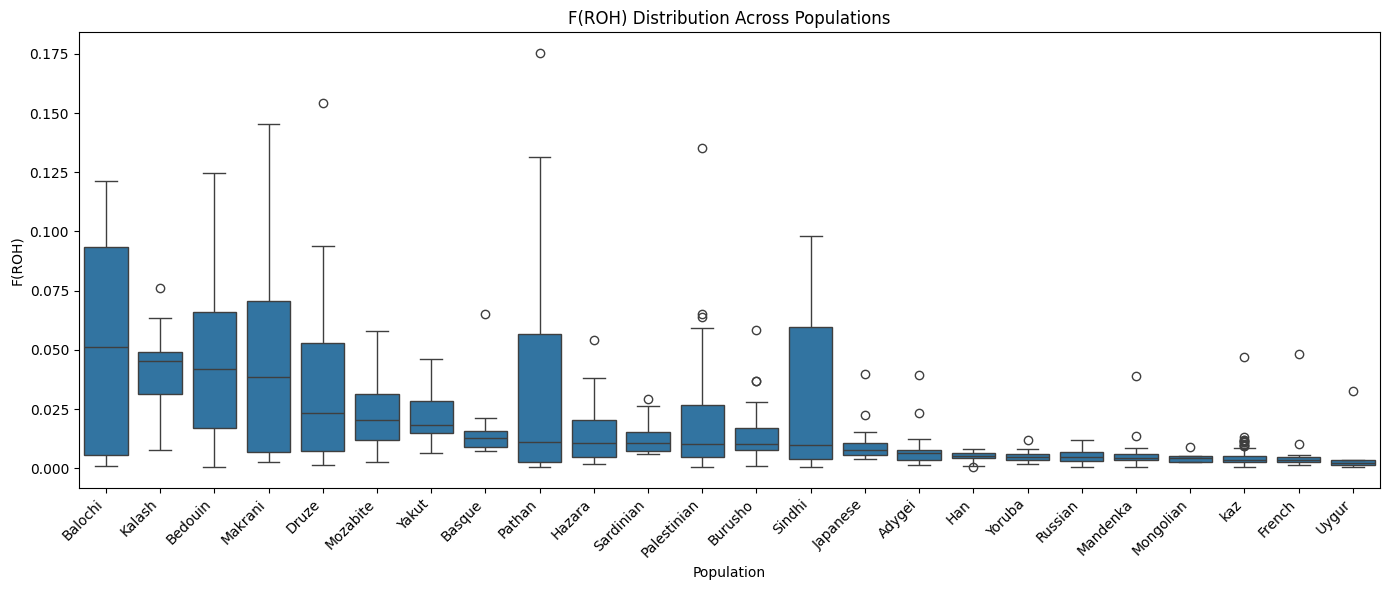

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load ROH summary
df = pd.read_csv("kaz_hgdp_roh.hom", delim_whitespace=True, skiprows=1,
                 names=["FID", "IID", "PHE", "CHR", "SNP1", "SNP2",
                        "POS1", "POS2", "KB", "NSNP", "DENSITY", "PHOM", "PHET"])

# Calculate FROH
froh = df.groupby("IID")["KB"].sum().reset_index()
froh["FROH"] = froh["KB"] / 2700000

# Load metadata and merge
meta = pd.read_csv("metadata_ROH.tsv", sep="\t")  # Columns: IID, Population
merged = froh.merge(meta, on="IID")

# List of populations to include

populations_to_keep = [
    "kaz", "Hazara", "Mongolian", "Uygur", "Burusho", "Pathan", "Sindhi", "Kalash",
    "Balochi", "Makrani", "Adygei", "Yakut", "Russian", "French", "Basque", "Sardinian",
    "Japanese", "Han", "Druze", "Palestinian", "Bedouin", "Yoruba", "Mandenka", "Mozabite"
]

# Filter to selected populations only
filtered = merged[merged["Population"].isin(populations_to_keep)]

# Sort populations by median FROH
order = filtered.groupby("Population")["FROH"].median().sort_values(ascending=False).index

# Plot
plt.figure(figsize=(14, 6))
sns.boxplot(data=filtered, x="Population", y="FROH", order=order)
plt.xticks(rotation=45, ha="right")
plt.title("F(ROH) Distribution Across Populations")
plt.ylabel("F(ROH)")
plt.xlabel("Population")
plt.tight_layout()
plt.show()